In [110]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import cvxpy as cp
import requests 
import tiktoken
import torch
import ray
import torch

from transformers import AutoTokenizer, AutoModel
from transformers import pipeline
from openai import OpenAI
from scipy.stats import spearmanr
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from scipy.optimize import minimize
from matplotlib.backends.backend_svg import FigureCanvasSVG

from prep_factor import PrepFactor
from functions.utils.system import *
from functions.utils.func import *

import warnings

warnings.filterwarnings('ignore')

##### Compile 3-4 articles per stock on a daily interval. From here retrieve its embeddings and 
##### perform zero-shot classification with labels specific towards positive sentiment

##### Run a sentiment analysis on these articles and retrieve this score

##### Calculate momentum factors for these stocks and then determine which ones to buy based of these three factors

### Get news data

In [40]:
def get_news_fmp(tickers):
    api_key = "f913bbd3dad0c411c864c0d960a711e7"
    base_url = "https://financialmodelingprep.com/api/v3/stock_news"
    limit = 1000
    all_data = []
    for ticker in tqdm(tickers):
        page = 0
        while True:
            url = f"{base_url}?tickers={ticker}&page={page}&limit={limit}&apikey={api_key}"
            response = requests.get(url)
            data = response.json()
            if not data or 'error' in data:
                break
            all_data.extend(data)
            page += 1
    
    df = pd.DataFrame(all_data).rename(columns={'symbol':'ticker', 'publishedDate':'date'}).drop('image', axis=1)
    df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
    df['date'] = pd.to_datetime(df['date'])
    df['text'] = df['text'].astype(str)
    df = df.set_index(['ticker', 'date']).sort_index(level=['ticker', 'date'])
    return df

In [3]:
tickers = ['AAPl', 'MSFT', 'AMZN', 'META', 'GOOGL']
news = get_news_fmp(tickers)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:38<00:00, 79.76s/it]


In [90]:
# Remove Duplicate Text
news = news.loc[~news.text.duplicated(keep='first')]

In [91]:
news.to_parquet(get_large_dir(False) / 'data_news.parquet.brotli', compression='brotli')

### Load in news data

In [175]:
start_date = '2010-01-01'
current_date = (date.today()).strftime('%Y-%m-%d')
tickers = ['AAPL', 'MSFT', 'AMZN', 'META', 'GOOGL']

In [89]:
# Shift all news one date forward to avoid lookahead bias
news = pd.read_parquet(get_large_dir(False) / 'data_news.parquet.brotli')
new_dates = news.index.get_level_values('date') + pd.DateOffset(days=1)
new_index = pd.MultiIndex.from_arrays([news.index.get_level_values('ticker'), new_dates], names=['ticker', 'date'])
news.index = new_index

### Get Article Embeddings

In [43]:
# Load the pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [44]:
# Function to preprocess sentences
def preprocess_sentence(sentence):
    # Make all words lowercase
    sentence = sentence.lower()
    return sentence
        
def get_bert_embedding(sentence):
    # Tokenize the sentence and convert it to tensor
    tokens = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    # Pass the tokens through the BERT model
    with torch.no_grad():
        outputs = model(**tokens)
    
    # Get the output representation of [CLS] token
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    # Convert the PyTorch tensor to a NumPy array
    cls_embedding = cls_embedding.numpy()
    return cls_embedding[0]

In [45]:
# Apply sentence preprocessing
news['cleaned_text'] = news['text'].apply(preprocess_sentence)
news['cleaned_title'] = news['title'].apply(preprocess_sentence)

In [46]:
# Apply the get_bert_embedding function to your cleaned sentences
start_time = time.time()
news['bert_emb_text'] = news['cleaned_text'].apply(get_bert_embedding)
news['bert_emb_title'] = news['cleaned_title'].apply(get_bert_embedding)
total_time = time.time() - start_time
print(f"Total Time: {total_time}")

Total Time: 10288.245993375778


In [47]:
news.to_parquet(get_large_dir(False) / 'data_news_bemb.parquet.brotli', compression='brotli')

### Get Label Embeddings

In [50]:
def cosine_similarity_matrix(embeddings, label_embedding):
    # Normalize the label_embedding
    label_norm = np.linalg.norm(label_embedding)
    if label_norm == 0:
        return np.zeros(len(embeddings))

    # Normalize the review embeddings
    embeddings_norm = np.linalg.norm(embeddings, axis=1)
    valid_indices = embeddings_norm != 0

    # Compute cosine similarity
    cosine_sim = np.zeros(len(embeddings))
    cosine_sim[valid_indices] = (embeddings[valid_indices] @ label_embedding) / (embeddings_norm[valid_indices] * label_norm)
    return cosine_sim

def zero_shot(embedding_data, embedding_col, labels, name):
    print("Retrieving label embeddings...")
    data = embedding_data.copy(deep=True)
    label_embeddings = [get_bert_embedding(label) for label in labels]
    embeddings_matrix = np.stack(data[embedding_col].values)

    print("Computing cosine similiarity with label embeddings...")
    for i, label_embedding in enumerate(label_embeddings):
        print("Label: ", i)
        column_name = f'{name}_{i}'
        data[column_name] = cosine_similarity_matrix(embeddings_matrix, label_embedding)
    return data

In [51]:
label_sentence = ["This stock shows promising potential for growth.",
                  "Market trends suggest a strong future for this stock.",
                  "Investor confidence in this stock is high.",
                  "The financial outlook for this stock looks positive.",
                  "Current analyses favor an upward trajectory for this stock."]

In [62]:
cosine_sim_text = zero_shot(news, 'bert_emb_text', label_sentence, 'cos_sim_text')
cosine_sim_title = zero_shot(news, 'bert_emb_title', label_sentence, 'cos_sim_title')

Retrieving label embeddings...
Computing cosine similiarity with label embeddings...
Label:  0
Label:  1
Label:  2
Label:  3
Label:  4
Retrieving label embeddings...
Computing cosine similiarity with label embeddings...
Label:  0
Label:  1
Label:  2
Label:  3
Label:  4


In [63]:
cosine_sim_text['cosine_sim_text_mean'] = cosine_sim_text[[f'cos_sim_text_{i}' for i in range(5)]].mean(axis=1)
cosine_sim_title['cosine_sim_title_mean'] = cosine_sim_title[[f'cos_sim_title_{i}' for i in range(5)]].mean(axis=1)

In [102]:
cosine_sim_comb = pd.merge(cosine_sim_text[['cosine_sim_text_mean', 'text', 'title']], cosine_sim_title[['cosine_sim_title_mean']],
                           left_index=True, right_index=True, how='inner')

In [103]:
cosine_sim_comb = cosine_sim_comb.loc[~cosine_sim_comb.text.duplicated(keep='first')]

In [109]:
AAPL = get_stock_data(cosine_sim_comb, 'MSFT')
AAPL.loc[AAPL.cosine_sim_text_mean < 0.5]

cosine_sim_text_mean  \
ticker date                               
MSFT   2019-08-30              0.499139   
       2020-02-20              0.489758   
       2020-05-01              0.478627   
       2021-07-30              0.492785   
       2021-09-09              0.413071   
       2021-10-20              0.481937   
       2023-02-09              0.441913   
       2023-02-11              0.460184   
       2023-08-02              0.487568   
       2023-08-18              0.491386   
       2023-09-29              0.454014   
       2023-11-08              0.488773   

                                                                text  \
ticker date                                                            
MSFT   2019-08-30  ExFAT, the Extended File Allocation Table, is ...   
       2020-02-20  Artificial intelligence is often portrayed as ...   
       2020-05-01  Apr.29 -- Glenn O'Donnell, Forrester Research ...   
       2021-07-30  Jul.28 -- LinkedIn CEO Ryan Roslansky discusse...   
       2021-09-09  Microsoft Corp (NASDAQ: MSFT) on Sept. 1 annou...   
       2021-10-20  Corsair Gaming Inc. ( CRSR , Financial) hasn't...   
       2023-02-09  At a Microsoft press event today where the com...   
       2023-02-11  Major U.S. companies laid off more than 81,000...   
       2023-08-02  Share buybacks (also called stock buybacks or ...   
       2023-08-18  Stock prices and returns are influenced by a c...   
       2023-09-29  Cloudflare, a connectivity cloud company, and ...   
       2023-11-08  OpenAI CEO Sam Altman and Microsoft CEO Satya ...   

                                                               title  \
ticker date                                                            
MSFT   2019-08-30  Microsoft wants to bring exFAT to the Linux ke...   
       2020-02-20  AI vs. humans? Microsoft’s Eric Horvitz sees t...   
       2020-05-01  Microsoft 'Still Shining' Through Coronavirus ...   
       2021-07-30  Workforce Experiencing 'The Great Reshuffle': ...   
       2021-09-09  Microsoft Stock Gears Up For A Run Higher, Opt...   
       2021-10-20             Corsair: A Rare Undervalued Gaming Gem   
       2023-02-09  Microsoft updates its Edge web browser with bu...   
       2023-02-11  2023 Layoffs: Yahoo Slashes 1,600 Jobs While G...   
       2023-08-02        3 Companies with the Biggest Share Buybacks   
       2023-08-18  Should Microsoft Pay A Special One-Time Divide...   
       2023-09-29  Cloudflare and Microsoft Partner to Optimize A...   
       2023-11-08  Microsoft CEO Satya Nadella has nothing but pr...   

                   cosine_sim_title_mean  
ticker date                               
MSFT   2019-08-30               0.714543  
       2020-02-20               0.796341  
       2020-05-01               0.807252  
       2021-07-30               0.833297  
       2021-09-09               0.758286  
       2021-10-20               0.818697  
       2023-02-09               0.812743  
       2023-02-11               0.816383  
       2023-08-02               0.787230  
       2023-08-18               0.852792  
       2023-09-29               0.802485  
       2023-11-08               0.803553

### Run Sentiment Analysis

In [ ]:
# Function to apply sentiment analysis
def analyze_sentiment(text):
    result = sentiment_pipeline(text)[0]
    return result['label'], result['score']

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_pipeline = pipeline('sentiment-analysis', model=model_name)

In [113]:
start_time = time.time()
cosine_sim_comb['sent_text'], cosine_sim_comb['conf_text'] = zip(*cosine_sim_comb['text'].apply(analyze_sentiment))
cosine_sim_comb['sent_title'], cosine_sim_comb['conf_title'] = zip(*cosine_sim_comb['title'].apply(analyze_sentiment))
total_time = time.time() - start_time
print(f"Total Time: {total_time}")

Total Time: 2805.3344881534576


In [114]:
cosine_sim_comb.to_parquet(get_large_dir(False) / 'data_news_signal.parquet.brotli', compression='brotli')

### News-Based Strategy

In [149]:
cosine_sim_comb['sent_score_text'] = cosine_sim_comb.apply(
    lambda row: 1 if row['sent_text'] == 'POSITIVE' and row['conf_text'] > 0.75 else 
               (-1 if row['sent_text'] == 'NEGATIVE' and row['conf_text'] > 0.75 else 0),
    axis=1)

cosine_sim_comb['sent_score_title'] = cosine_sim_comb.apply(
    lambda row: 1 if row['sent_title'] == 'POSITIVE' and row['conf_title'] > 0.75 else 
               (-1 if row['sent_title'] == 'NEGATIVE' and row['conf_title'] > 0.75 else 0),
    axis=1)

In [210]:
signal = cosine_sim_comb[['cosine_sim_text_mean', 'sent_score_text', 'cosine_sim_title_mean', 'sent_score_title']]

In [211]:
m_signal = signal.groupby(level='ticker').resample('M', level='date').agg({
    'cosine_sim_text_mean': 'mean',
    'cosine_sim_title_mean': 'mean',
    'sent_score_text': 'sum',
    'sent_score_title': 'sum'
})

In [183]:
aapl_ret = get_stock_data(price, 'AAPL')
section = set_timeframe(aapl_ret, '2019-05-31', '2019-06-30')

<AxesSubplot:xlabel='ticker,date'>

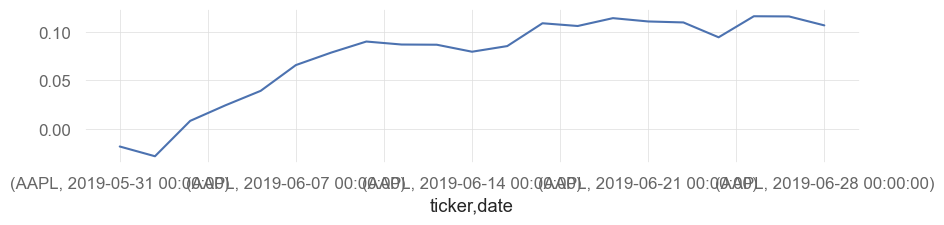

In [187]:
section.RET_01.cumsum().plot(figsize=(10, 2))

In [191]:
def generate_buy_signal(row):
    # Define thresholds
    cosine_sim_threshold = 0.8
    sentiment_threshold = 0

    # Calculate average cosine similarity
    avg_cosine_sim = (row['cosine_sim_text_mean'] + row['cosine_sim_title_mean']) / 2

    # Calculate total sentiment score
    total_sentiment = row['sent_score_text'] + row['sent_score_title']

    # Define conditions for strong, mid, and low buy
    if avg_cosine_sim >= cosine_sim_threshold and total_sentiment > sentiment_threshold:
        return 'strong buy'
    elif avg_cosine_sim >= cosine_sim_threshold or total_sentiment > sentiment_threshold:
        return 'mid buy'
    else:
        return 'low buy'

In [212]:
price = get_data_fmp(tickers, start_date, current_date)
price = create_return(price, [1])

Fetching data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28ticker/s]


In [214]:
m_signal['buy_signal'] = m_signal.apply(generate_buy_signal, axis=1)

In [215]:
shift_m = m_signal.reset_index()
shift_m['date'] = shift_m['date'] + pd.offsets.MonthBegin(1)
shift_m = shift_m.set_index(['ticker', 'date'])

In [222]:
# Create a date range that covers your daily data period
date_range = pd.date_range(start=price.index.get_level_values('date').min(),
                           end=price.index.get_level_values('date').max(),
                           freq='D')

# Create a complete MultiIndex for reindexing
complete_index = pd.MultiIndex.from_product(
    [shift_m.index.get_level_values('ticker').unique(), date_range],
    names=['ticker', 'date']
)

daily_m_signal = shift_m.reindex(complete_index, method='ffill')
daily_m_signal = daily_m_signal.dropna()

In [239]:
news_port = pd.merge(daily_m_signal, price[['RET_01']], left_index=True, right_index=True, how='inner')

In [259]:
# Calculate historical volatility (standard deviation of returns)
weights = {'strong buy': 1.0, 'mid buy': 0.50, 'low buy': -0.10}
volatility = news_port.groupby(level='ticker')['RET_01'].rolling(window=30).std().droplevel(0)
inverse_volatility = 1 / volatility

# Apply initial signal weights
news_port['signal_weight'] = news_port.apply(lambda row: weights.get(row['buy_signal'], 0), axis=1)

# Combine with inverse volatility weights
news_port['combined_weight'] = news_port['signal_weight'] * inverse_volatility
news_port['abs_weight'] = news_port['combined_weight'].abs()

# Normalize the combined weights
sum_combined_weights_by_day = news_port.groupby('date')['abs_weight'].sum()
news_port['normalized_weight'] = news_port.apply(lambda row: row['combined_weight'] / sum_combined_weights_by_day[row.name[1]] if sum_combined_weights_by_day[row.name[1]] != 0 else 0, axis=1)

# Compute the final weighted daily returns
news_port['final_weighted_return'] = news_port['RET_01'] * news_port['normalized_weight']
portfolio_daily_returns = news_port.groupby('date')['final_weighted_return'].sum()

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2010-02-17   2010-02-17
End Period                 2023-12-22   2023-12-22
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          331.61%      439.68%
CAGR﹪                     7.56%        8.77%

Sharpe                     0.69         0.74
Prob. Sharpe Ratio         99.46%       99.71%
Smart Sharpe               0.68         0.72
Sortino                    0.97         1.09
Smart Sortino              0.95         1.06
Sortino/√2                 0.69         0.77
Smart Sortino/√2           0.67         0.75
Omega                      1.14         1.14

Max Drawdown               -34.1%       -23.96%
Longest DD Days            718          838
Volatility (ann.)          17.4%        18.81%
R^2                        0.26         0.26
Information Ratio          0.01         0.01
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-09-24,2022-04-04,2023-01-09,838,-23.963828,-22.513121
2,2011-01-19,2011-06-24,2011-12-08,324,-21.043029,-19.560882
3,2018-07-26,2018-11-19,2019-04-29,278,-18.754201,-18.282327
4,2010-04-16,2010-07-06,2010-10-14,182,-18.368398,-17.661384
5,2020-01-31,2020-03-23,2020-09-04,218,-16.338357,-15.207505


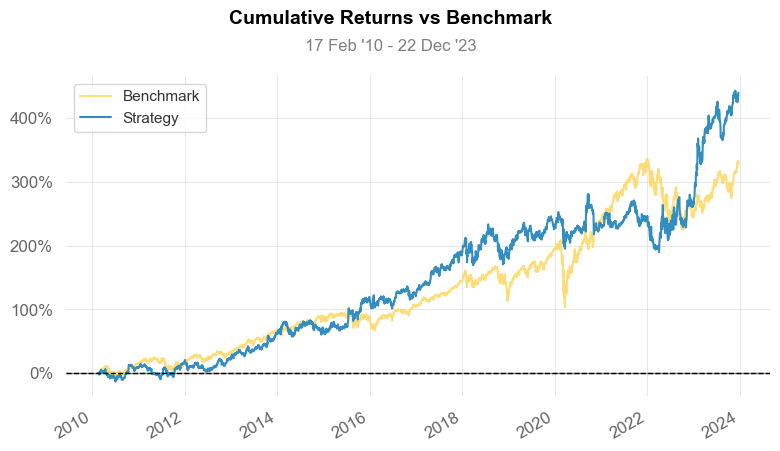

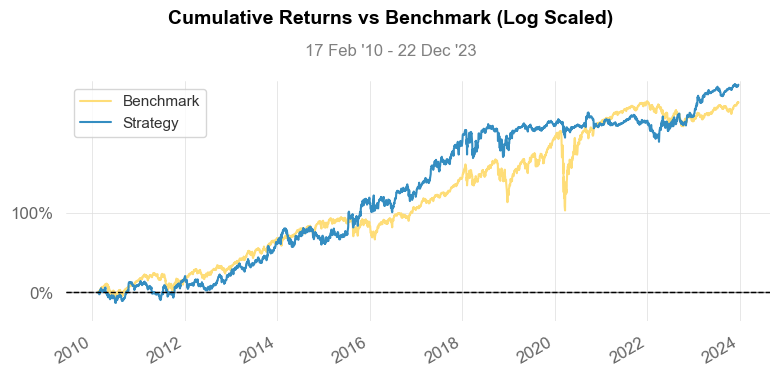

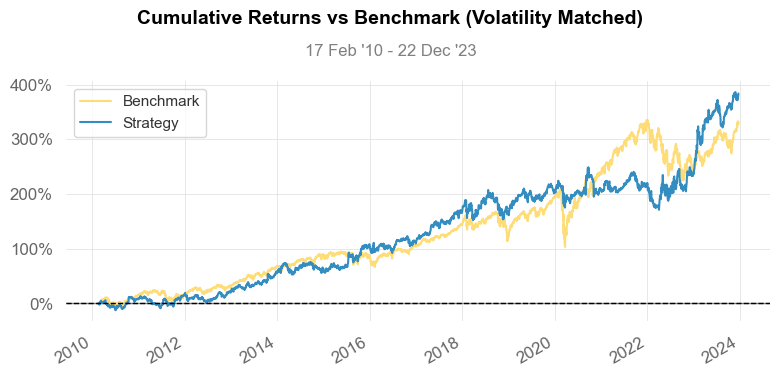

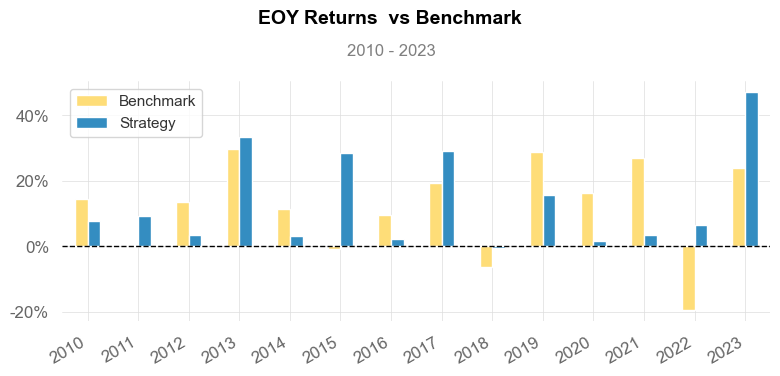

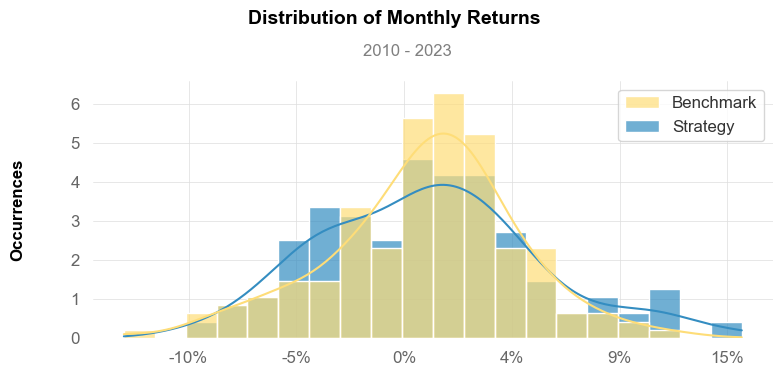

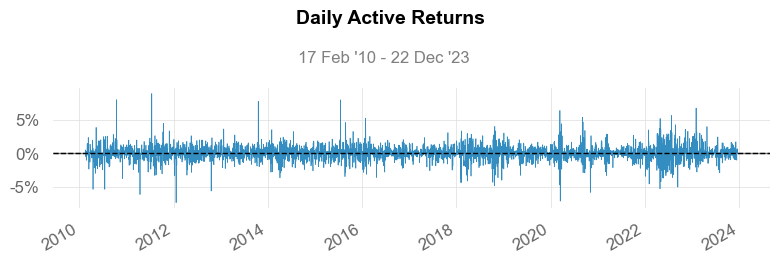

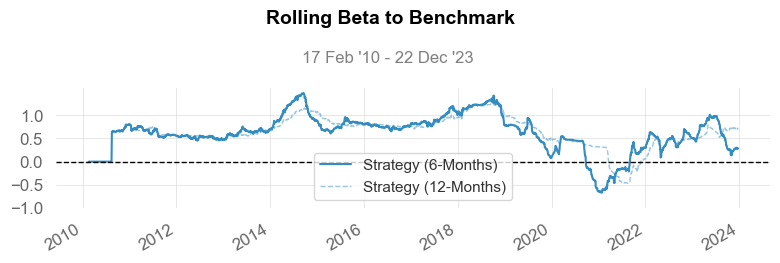

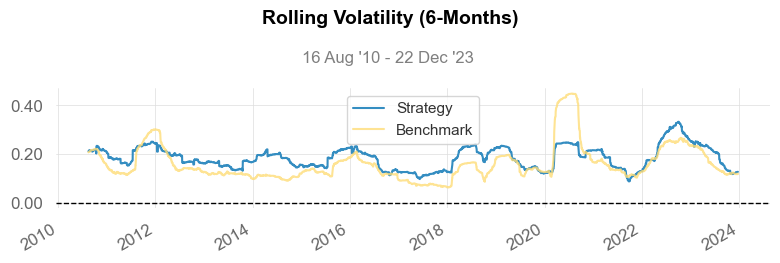

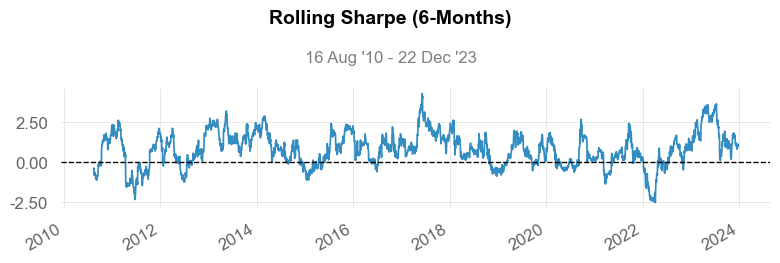

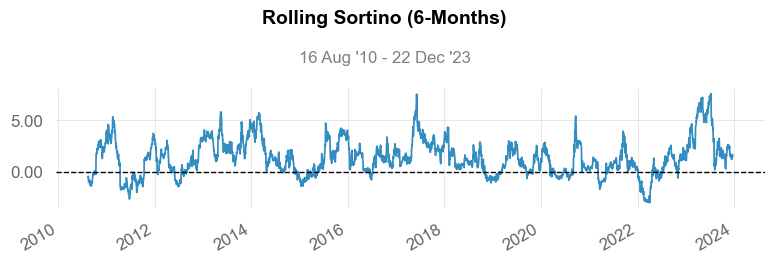

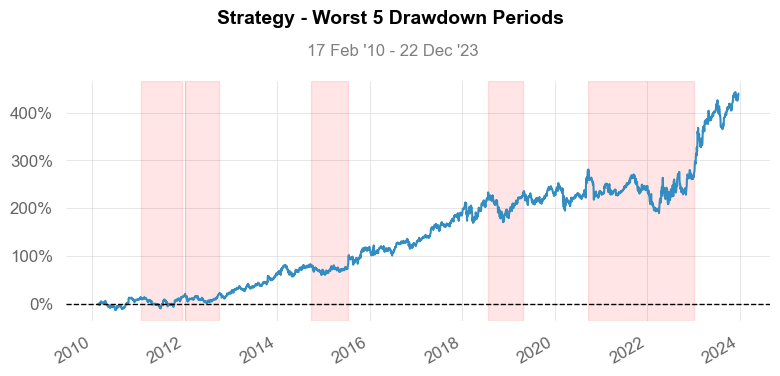

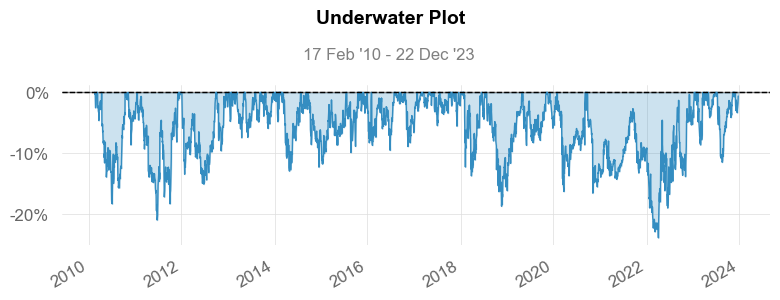

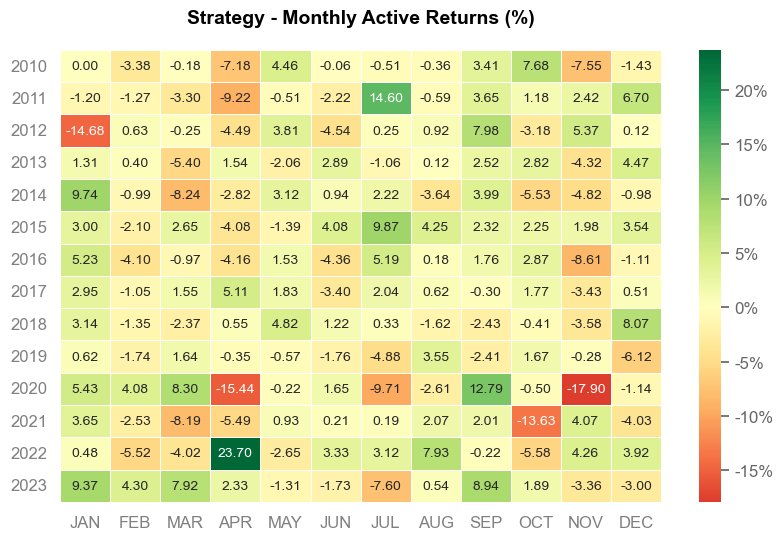

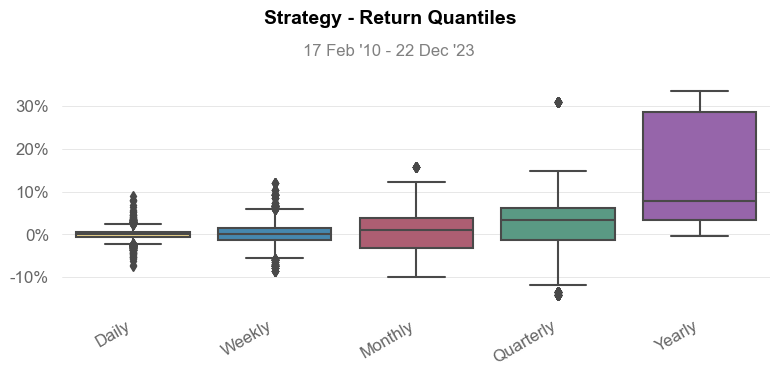

In [260]:
qs.reports.full(portfolio_daily_returns, 'SPY')

### Naive long-hold strategy

In [196]:
naive_long_ret = price.groupby('date')['RET_01'].sum() * (1/len(tickers))

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2010-01-05   2010-01-05
End Period                 2023-12-21   2023-12-21
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          317.10%      1,742.43%
CAGR﹪                     7.31%        15.49%

Sharpe                     0.68         1.0
Prob. Sharpe Ratio         99.36%       99.99%
Smart Sharpe               0.63         0.93
Sortino                    0.94         1.45
Smart Sortino              0.87         1.34
Sortino/√2                 0.67         1.02
Smart Sortino/√2           0.62         0.95
Omega                      1.2          1.2

Max Drawdown               -34.1%       -46.79%
Longest DD Days            717          682
Volatility (ann.)          17.4%        23.64%
R^2                        0.64         0.64
Information Ratio          0.05         0.05
Calmar            

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-12-28,2022-11-03,2023-11-09,682,-46.787366,-44.387206
2,2020-02-20,2020-03-16,2020-05-19,90,-27.467293,-26.779413
3,2018-08-31,2018-12-24,2019-04-18,231,-27.029403,-23.804472
4,2010-04-23,2010-07-02,2010-10-14,175,-16.471268,-16.046480
5,2020-09-03,2020-09-23,2021-01-22,142,-16.461921,-16.076005


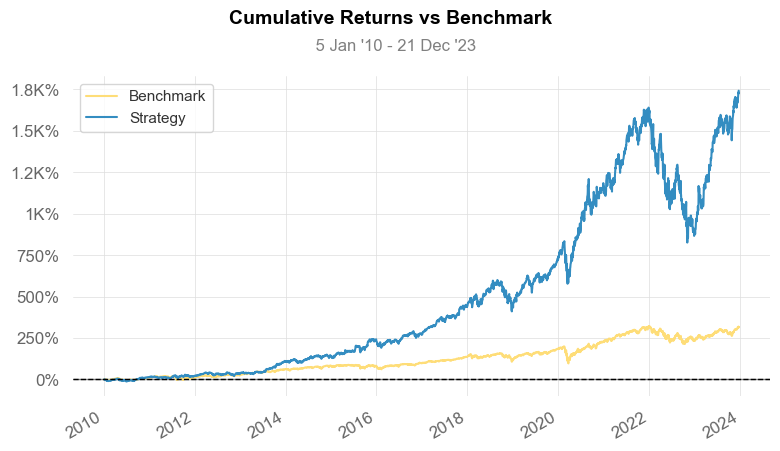

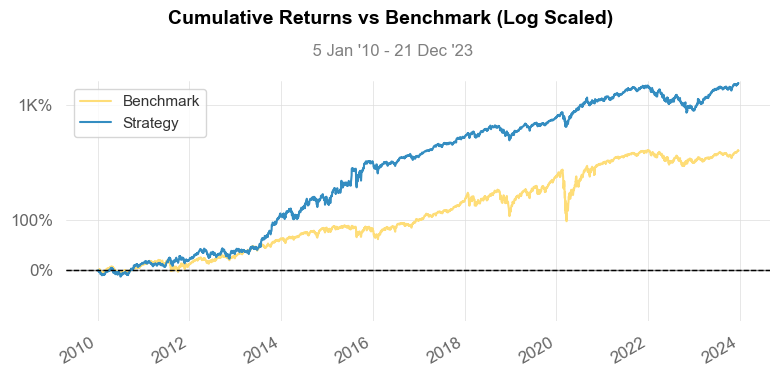

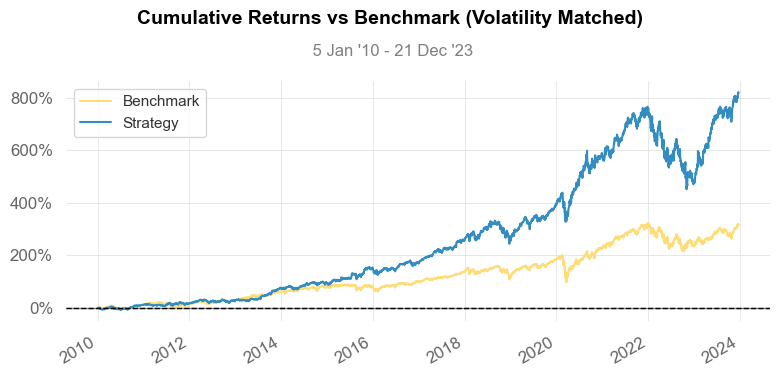

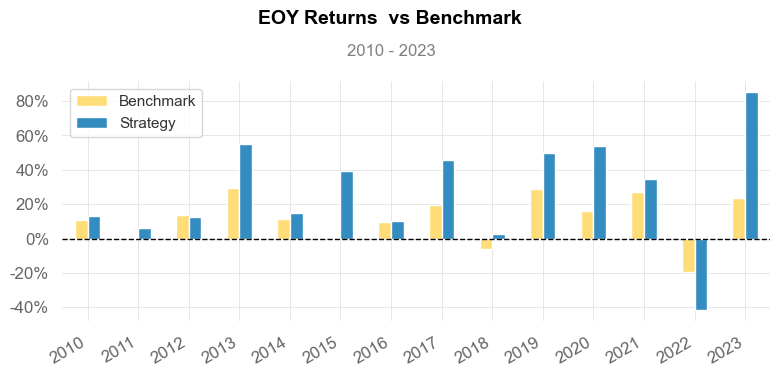

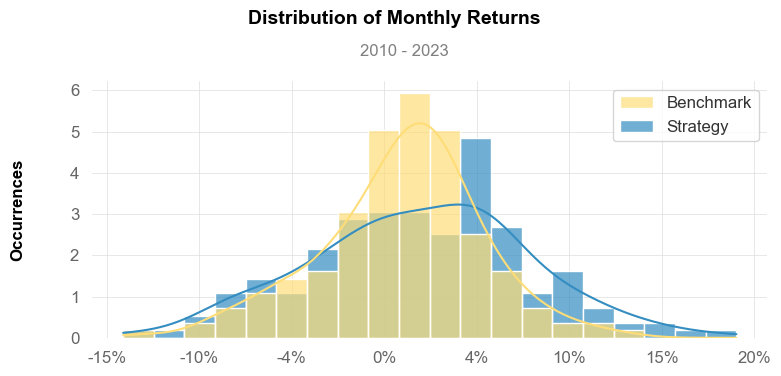

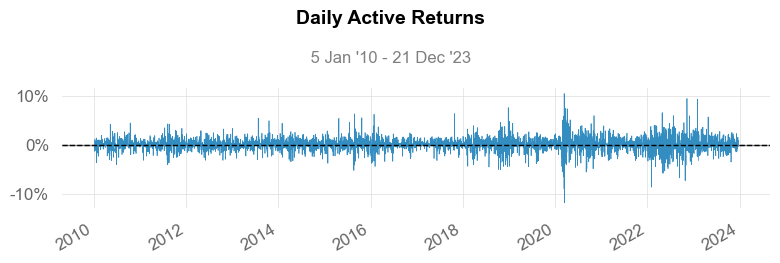

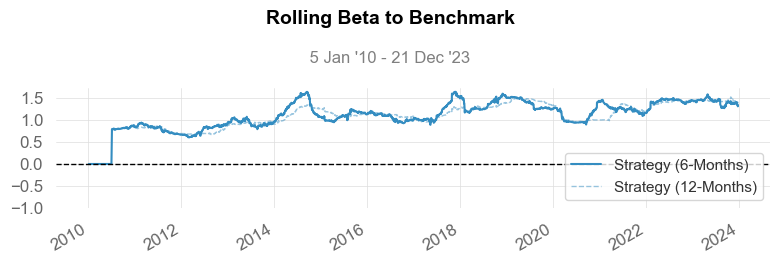

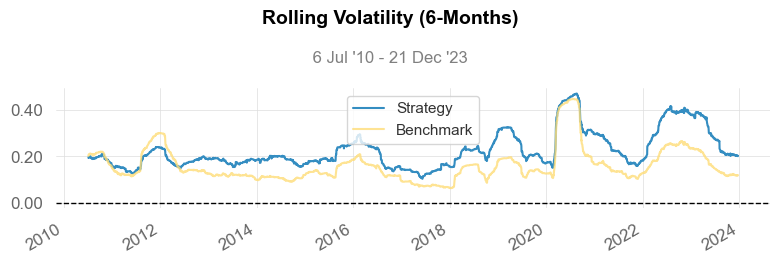

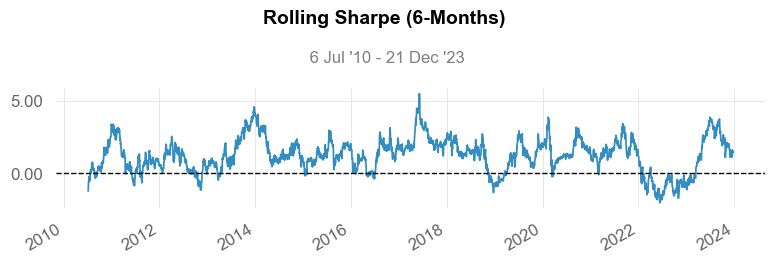

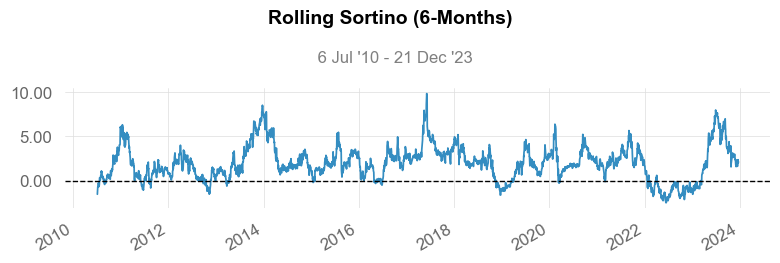

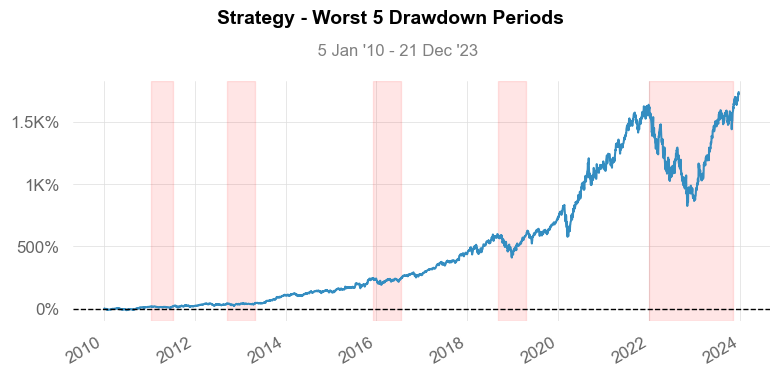

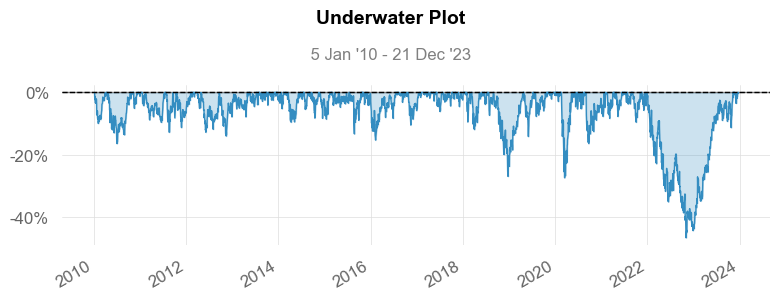

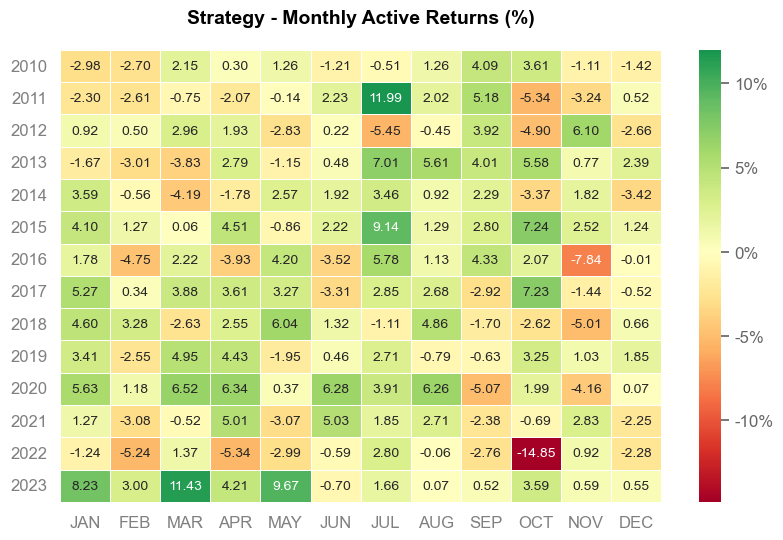

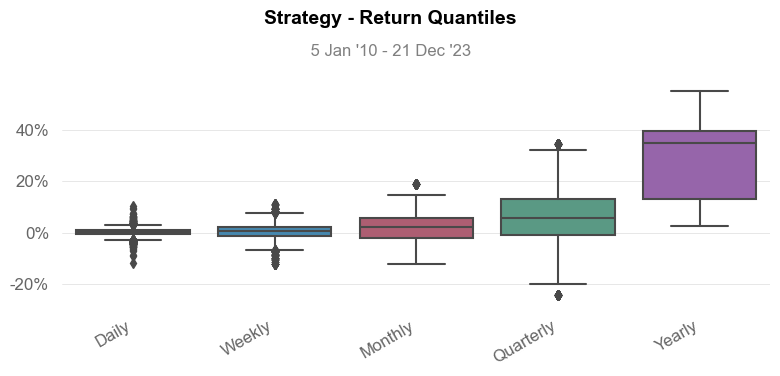

In [31]:
qs.reports.full(naive_long_ret, 'SPY')